In [72]:
# Peri Akiva, Arpit Shah
import os
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.base import TransformerMixin
from collections import defaultdict
from sklearn.pipeline import Pipeline
from __future__ import division
from sklearn.svm import LinearSVC
import pprint
from math import isnan
import numpy as np
from sklearn.datasets import load_iris
from sklearn import cross_validation
from sklearn.linear_model import Ridge
from collections import Counter
#from spacy.en import English
import spacy
import re
import pickle as p
from sklearn.externals import joblib
import peakutils
from datetime import datetime
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import json
import numpy as np
import sys
from textblob import TextBlob
import string

In [6]:
class predictors(TransformerMixin):
    def transform(self,X,**transform_params):
        return [clean_text(text) for text in X]
    def fit(self,X,y=None,**fit_params):
        return self
    def get_params(self,deep=True):
        return {}
    
def clean_text(text):
    return text.strip().lower()
def spacy_tokenizer(sentence):
    tokens = parser(sentence)
    tokens = [tok.lemma_.lower().strip() if tok.lemma_!="-PRON-" else tok.lower_ for tok in tokens]
    tokens = [tok for tok in tokens if (tok not in stopwords and tok not in punctuations)]
    return tokens


In [7]:
def csvToListTuples(csvPath):
    df = pd.read_csv(csvPath,usecols=['Sentiment','SentimentText'])
    rejects=['&','http']
    df = df[df.SentimentText.str.contains("&") == False]
    df = df[df.SentimentText.str.contains("http") == False]
    labeledData=[(row['SentimentText'],row['Sentiment']) for index,row in df.iterrows()]
    with open('labeledData.pkl','wb') as f:
        p.dump(labeledData,f)
    return labeledData

In [8]:
def splitData(labeledData):
    trainLabeled=[]
    testLabeled=[]
    n=0
    for i in labeledData:
        if n%10==0:
            testLabeled.append(i)
        else:
            trainLabeled.append(i)
        n=n+1
    return trainLabeled,testLabeled

In [110]:
def DFDuplicateHandle(df):
    df = df.groupby('enddate',as_index=False)['adjusted_approve','adjusted_disapprove'].mean()
    df['enddate'] = pd.to_datetime(df['enddate'])
    df = df.sort_values(by='enddate')
    #print df
    return df

def csvToDataFrame(pathToCsv):
    return pd.read_csv(pathToCsv,usecols=['startdate','enddate','pollster','adjusted_approve','adjusted_disapprove'])

def plotData(test,pred_data):
    fig = plt.figure()
    plt.plot(range(0,len(pred_data)),pred_data)
    fig.savefig('movingavg.png')
    #plt.show()
    

def plotDF(df,x,y,index_track):
    #df['enddate'] = pd.to_datetime(df['enddate'])
    fig = plt.figure()
    plot = fig.add_subplot(111)

    def movingAvg(y):
        ynew=[50]
        ySum=50
        for i,k in zip(range(1,len(y)),y):
            ySum+=y[i]
            ynew.append(ySum/(i+1))
        return ynew

    ynew=movingAvg(y)

    def on_plot_hover(event):
        #x= event.xdata
        print event
    plot.plot_date(x,ynew,'r-',linewidth=0.5)
    plot.plot_date(x,y,'y-',linewidth=0.5,label='Trumps Attitude in Social Media (0-100, lower is worse), Naive Bayes Approach')
    #plot.plot_date(dic.keys(),dic.values(),'y-',linewidth=0.5)
    plot.plot_date(df['enddate'],df['adjusted_approve'],'b-',linewidth=0.4,label='Approval Rating')
    plot.plot_date(df['enddate'],df['adjusted_disapprove'],'r-',linewidth=0.4,label='Disapproval Rating')
    plot.grid(color='black',linestyle='-',linewidth=0.1)
    plt.xlabel('Date')
    plt.ylabel('Approval/Disapproval Rate')
    plt.ylim(0,100,5)
    plt.title('Trumps Approval Rating Compared to Twitter Users Sentiments')
    annot = plt.annotate("",xy=(0,0),xytext=(20,20),textcoords="offset points",bbox=dict(boxstyle="round",fc="w"),arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)
    fig.canvas.mpl_connect('motion_notify_event',on_plot_hover)
    plot.plot_date(index_track.keys(),index_track.values(),'k*',markersize=1,label='Trumps Attitude in Social Media (0-100, lower is worse), SVM Approach')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig.savefig('graph.png')
    plt.show()
    
    #plt.show()


def impactForText(string):
    text = TextBlob(string)
    polarity = text.sentiment.polarity
    if polarity!=0:
        return polarity*len(re.sub("[^\w]"," ",string).split())*100
    return 0


In [10]:
def impactForList(tweets):
    # overAll is an approval index ranging from 0-100

    overAll = 0
    for i in tweets:
        #print impactForText(i)
        overAll+=impactForText(i)
    #normalize the data
    #overAll=(overAll+100)/2
    if overAll<=-2000:
        return -2000
    elif overAll>=2000:
        return 2000
    else:
        return overAll

def impactForData(dic):
    impactDict = {}
    for i in dic:
        impactDict[i] = impactForList(dic[i])
    # returns approval index per day of tweets
    return impactDict

def compareTBsvm(test):
    correctCount=0
    falseCount=0
    total=len(test)
    for i in test:
        text=TextBlob(i[0])
        try:
            polarity = text.sentiment.polarity
            if (polarity<0 and i[1]==int(0)) or (polarity>0 and i[1]==int(1)):
                correctCount=correctCount+1
            elif (polarity>0 and i[1]==0) or (polarity<0 and i[1]==1):
                falseCount+=1
        except:
            continue 
    return correctCount,total


In [11]:
parser = spacy.load('en')
punctuations = string.punctuation
df = csvToDataFrame('/home/native/projects/semanticImpactAnalysis/approval_polllist.csv')
df = DFDuplicateHandle(df)

In [12]:
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer,ngram_range=(1,1))
classifier=LinearSVC()
pipe = Pipeline([("cleaner",predictors()),('vectorizer',vectorizer),('classifier',classifier)])

In [13]:
if os.path.exists('labeledData.pkl'):
    with open('labeledData.pkl','rb') as f:
        labeledData = p.load(f)
else:
    labeledData = csvToListTuples('/home/native/projects/semanticImpactAnalysis/SemAnLabeled.csv')

if os.path.getsize('labeledData.pkl')<10:
    os.remove('labeledData.pkl')

In [14]:
train,test = splitData(labeledData[:8000])

In [92]:
pipe.fit([x[0] for x in train],[x[1] for x in train])

Pipeline(memory=None,
     steps=[('cleaner', <__main__.predictors object at 0x7f6b1b8e1f10>), ('vectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
       ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [95]:
joblib.dump(pipe,'classifier.pkl')

['classifier.pkl']

In [15]:
pipe = joblib.load('classifier.pkl') 

In [16]:
trumpTweets = p.load(open("trumps_tweets_dict.p","rb"))
test2 = [x for x in trumpTweets.values()]

In [113]:
pred_data = pipe.predict([x[0] for x in test])

In [115]:
pred_data = pipe.predict([x[0] for x in test2])

In [114]:
#for (sample,pred) in zip(test,pred_data):
#    print sample,pred
print "Accuracy SVM Approach: ", accuracy_score([x[1] for x in test], pred_data)


Accuracy SVM Approach:  0.76625


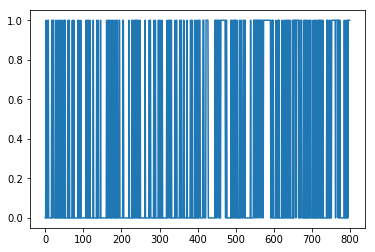

In [22]:
plotData(test,pred_data)

In [144]:
print "NBayes: (correct classification, total testing): " + str(compareTBsvm(test))

NBayes: (correct classification, total testing): (303, 800)


In [90]:
def movingAverage(pred_data,trumpTweets):
    sumSoFar=0
    keys=sorted(trumpTweets.keys())
    index_track=defaultdict(list)
    moveAvg=[]
    for i in xrange(1,len(pred_data)):
        sumSoFar+=pred_data[i]
        if i>10:
            sumSoFar-=pred_data[i-10]
            moveAvg.append(round((float(sumSoFar/10*1.0)*100),2))
            index_track[moveAvg[-1]].append(keys[i])
        else:
            if len(moveAvg)==0: moveAvg.append(sumSoFar)
            else: moveAvg.append(round((float(sumSoFar/len(moveAvg)*1.0)*100),2))
            index_track[moveAvg[-1]].append(keys[i])

    return moveAvg,index_track 

def movingAverage2(pred_data,trumpTweets):
    sumSoFar=0
    keys=sorted(trumpTweets.keys())
    index_track={}
    moveAvg=[]
    for i in xrange(1,len(pred_data)):
        sumSoFar+=pred_data[i]
        if i>10:
            sumSoFar-=pred_data[i-10]
            moveAvg.append(round((float(sumSoFar/10*1.0)*100),2))
            index_track[keys[i]]=moveAvg[-1]
        else:
            if len(moveAvg)==0: moveAvg.append(sumSoFar)
            else: moveAvg.append(round((float(sumSoFar/len(moveAvg)*1.0)*100),2))
            index_track[keys[i]]=moveAvg[-1]

    return moveAvg,index_track 

In [91]:
seven_day_moving_avg,index_track = movingAverage2(pred_data,trumpTweets)
#index_track = {k: index_track[k] for k in index_track if not isnan(k)}
#del index_track[0]

In [92]:
print("\n".join("{}\t{}".format(k, v) for k, v in index_track.items()))
print seven_day_moving_avg
print pred_data
print max(index_track.keys())
print min(index_track.keys())


2017-11-14	40.0
2017-06-10	30.0
2017-10-29	80.0
2017-11-11	70.0
2017-08-17	60.0
2017-10-03	40.0
2017-05-25	30.0
2017-11-03	70.0
2017-11-04	70.0
2017-11-05	70.0
2017-11-06	70.0
2017-10-02	50.0
2017-11-08	60.0
2017-11-09	70.0
2017-08-18	70.0
2017-10-01	60.0
2017-11-24	50.0
2017-10-14	30.0
2017-06-17	40.0
2017-08-26	40.0
2017-10-17	60.0
2017-10-10	20.0
2017-06-09	30.0
2017-10-12	30.0
2017-10-13	30.0
2017-06-04	50.0
2017-06-05	50.0
2017-06-06	40.0
2017-06-07	40.0
2017-10-18	50.0
2017-06-01	60.0
2017-06-02	60.0
2017-05-17	10.0
2017-05-24	20.0
2017-05-05	60.0
2017-11-01	60.0
2017-07-30	40.0
2017-04-30	60.0
2017-07-18	30.0
2017-06-16	40.0
2017-06-13	40.0
2017-05-13	20.0
2017-11-18	20.0
2017-08-19	70.0
2017-05-10	30.0
2017-11-17	10.0
2017-11-16	20.0
2017-10-09	30.0
2017-05-11	20.0
2017-11-13	50.0
2017-11-12	60.0
2017-02-28	40.0
2017-11-10	70.0
2017-02-26	50.0
2017-02-27	50.0
2017-02-24	40.0
2017-02-25	40.0
2017-02-22	30.0
2017-02-23	30.0
2017-02-20	30.0
2017-02-21	40.0
2017-05-12	20.0
2017-04-

In [125]:
print trumpTweets.keys()[288]


2017-10-20


In [94]:
print index_track.values()
dates=[]

[40.0, 30.0, 80.0, 70.0, 60.0, 40.0, 30.0, 70.0, 70.0, 70.0, 70.0, 50.0, 60.0, 70.0, 70.0, 60.0, 50.0, 30.0, 40.0, 40.0, 60.0, 20.0, 30.0, 30.0, 30.0, 50.0, 50.0, 40.0, 40.0, 50.0, 60.0, 60.0, 10.0, 20.0, 60.0, 60.0, 40.0, 60.0, 30.0, 40.0, 40.0, 20.0, 20.0, 70.0, 30.0, 10.0, 20.0, 30.0, 20.0, 50.0, 60.0, 40.0, 70.0, 50.0, 50.0, 40.0, 40.0, 30.0, 30.0, 30.0, 40.0, 20.0, 60.0, 30.0, 40.0, 20.0, 30.0, 50.0, 60.0, 10.0, 20.0, 10.0, 80.0, 20.0, 20.0, 20.0, 40.0, 50.0, 40.0, 60.0, 40.0, 50.0, 30.0, 10.0, 60.0, 60.0, 30.0, 70.0, 50.0, 70.0, 60.0, 30.0, 60.0, 30.0, 40.0, 50.0, 30.0, 60.0, 40.0, 50.0, 50.0, 50.0, 40.0, 60.0, 40.0, 50.0, 50.0, 60.0, 50.0, 40.0, 30.0, 40.0, 20.0, 40.0, 30.0, 20.0, 70.0, 30.0, 50.0, 40.0, 40.0, 30.0, 40.0, 40.0, 30.0, 50.0, 40.0, 40.0, 40.0, 30.0, 30.0, 60.0, 40.0, 60.0, 60.0, 30.0, 40.0, 50.0, 30.0, 40.0, 40.0, 40.0, 50.0, 50.0, 60.0, 60.0, 60.0, 60.0, 40.0, 20.0, 40.0, 30.0, 30.0, 40.0, 40.0, 40.0, 40.0, 50.0, 44.44, 40.0, 50.0, 40.0, 60.0, 80.0, 40.0, 30.0, 30

In [198]:
plotData(index_track.values(),seven_day_moving_avg)

In [143]:
print "Negative (0) and Positive(1) counter: " + str(Counter(pred_data))

Negative (0) and Positive(1) counter: Counter({0: 176, 1: 133})


2017-01-20 : 2000
2017-01-21 : 1153.75
2017-01-22 : 1494.66666667
2017-01-23 : 346.666666667
2017-01-24 : 2000
2017-01-25 : -1480.89285714
2017-01-26 : 766.428571429
2017-01-27 : 847.25
2017-01-28 : -1592.14285714
2017-01-29 : -2000
2017-01-30 : -127.409090909
2017-01-31 : -1496.09375
2017-02-01 : 561.022727273
2017-02-02 : 1345.6344697
2017-02-03 : 2000
2017-02-04 : -2000
2017-02-05 : -87.5833333333
2017-02-06 : 46.4880952381
2017-02-07 : 652.5
2017-02-08 : 1892.6984127
2017-02-09 : 1717.01028139
2017-02-10 : -661.25
2017-02-11 : 2000
2017-02-12 : -1081.83035714
2017-02-13 : 2000
2017-02-14 : 677.575757576
2017-02-15 : 1360.0
2017-02-16 : -1040.25
2017-02-17 : 584.333333333
2017-02-18 : 89.8333333333
2017-02-19 : 0
2017-02-20 : 183.928571429
2017-02-21 : 239.318181818
2017-02-22 : 2000
2017-02-23 : 725.0
2017-02-24 : -2000
2017-02-25 : 2000
2017-02-26 : -630.833333333
2017-02-27 : 2000
2017-02-28 : 600.0
2017-03-01 : 245.454545455
2017-03-02 : 500.0
2017-03-03 : 2000
2017-03-04 : -200

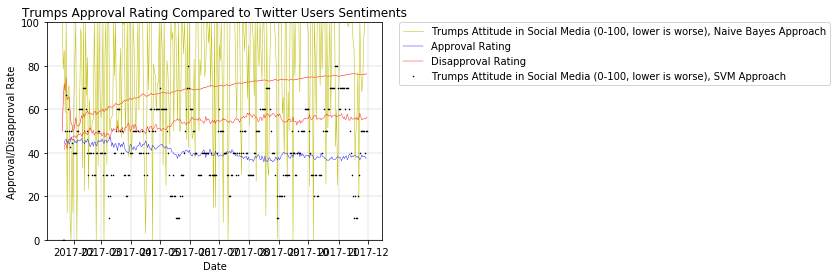

In [111]:
df = csvToDataFrame('/home/native/projects/semanticImpactAnalysis/approval_polllist.csv')
df = DFDuplicateHandle(df)
#df.to_csv('cleanPollData.csv')
#print DFtoDict(df)

x= impactForData(trumpTweets)
keys = sorted(x.iterkeys())
maxi = max(x.values())
mini = min(x.values())
for key in sorted(x.keys()):
    print "%s : %s" % (key,x[key])
xnew={}
for key in sorted(x.keys()):
    xnew[key]=x[key]+(-mini)
    xnew[key]=int((xnew[key]/(-mini))*100)/2
#for key in sorted(xnew.keys()):
#    print "%s : %s" % (key,xnew[key])
print xnew
print min(xnew.values())
plotDF(df,sorted(xnew.keys()),[xnew[key] for key in sorted(xnew.keys())],index_track)
#print np.mean(x.values())
#tdp = {'day1':['i hate sushi','work with me here','trump is evil','why are you killing me'],'day2':['evil hate dislike shit no bad']}
#print impactForData(tdp)
#print impactForData(tpd)
#tw = ["i hate sushi","i love europe","trump is not good for america","where is my phone?"]
#print impactForList(tw)